In [3]:
import torch 
import matplotlib.pyplot as plt

from PIL import Image
import torch.nn.functional as F

from torchvision import transforms, models
import urllib.request

data loading and preprocesing

In [ ]:
def preprocess_image(img_path):

    """Load and preprocess images for PyTorch models."""

    img = Image.open(img_path).convert("RGB")

    #Transforms used by imagenet models
    transform = transforms.Compose([
        transforms.Resize((225, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return transform(img).unsqueeze(0)



In [6]:
def display_output(output,n=5):

    """Display the top n categories predicted by the model."""
    
    # Download the categories
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")

    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Show top categories per image
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, n)

    for i in range(top_prob.size(0)):
        print(categories[top_catid[i]], top_prob[i].item())

    return top_catid[0]

(-0.5, 499.5, 387.5, -0.5)

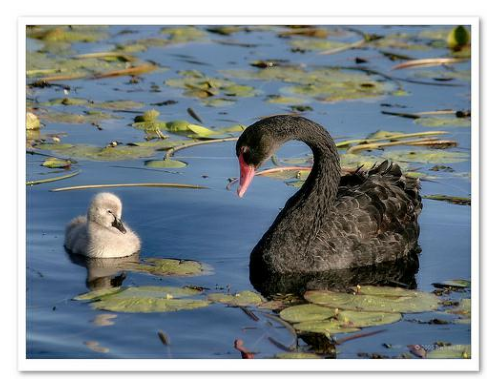

In [10]:
# Load a sample image
import os 
# img_path = os.path.join(os.getcwd(), "imagenet_val/00100/87469483327336.jpg")
img_path = "c:\\Users\\harsh\\OneDrive\\Desktop\\xai-honors\\imagenet_val/00100/87469483327336.jpg"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.axis("off")

### model loading 

In [11]:
# Load the pre-trained model (e.g., VGG16)
model = models.vgg16(pretrained=True)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

c:\Users\harsh\OneDrive\Desktop\xai-honors\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harsh\OneDrive\Desktop\xai-honors\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\harsh/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:09<00:00, 7.93MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:


# Preprocess the image
original_img_tensor = preprocess_image(img_path)
original_img_tensor = original_img_tensor.to(device)

# Clone tensor to avoid in-place operations
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_() # Enable gradient tracking

predictions = model(img_tensor)
print(f"Predictions: {predictions.shape}")

# Decode the output
display_output(predictions,n=5)


Predictions: torch.Size([1, 1000])
black swan 0.9973750114440918
American coot 0.002328003291040659
goose 0.00025539056514389813
red-breasted merganser 1.5450317732756957e-05
European gallinule 1.2803071513189934e-05


tensor(100)

In [16]:
model.zero_grad() # Clear previous gradients
target_class = predictions.argmax()
print(f"Target class: {target_class}")

Target class: 100


In [18]:
predictions[:, target_class].backward()# Backpropagation

In [19]:
# results 
standard_backprop = img_tensor.grad.detach().cpu().numpy()
print(f"Standard backprop shape: {standard_backprop.shape}")

Standard backprop shape: (1, 3, 224, 224)


In [22]:
import numpy as np
def process_grads(grads_in,activation="None",skew=True,normalize=True,greyscale=False):
    """
    Process the gradients for visualization.

    Parameters:
        grads (np.array): Gradients to be processed.
        activation (str): Activation function to be applied to the gradients. Options: "relu", "abs".
        skew (bool): Whether to skew the gradients.

    Returns:
        np.array: Processed gradients.
    """
    # Copy the gradients
    grads = np.copy(grads_in)
    
    # Transpose the gradients
    if len(grads.shape) >= 3:
        grads = np.transpose(grads, (1, 2, 0))

    # Get the absolute value of the gradients
    if activation == "relu":
        grads = np.maximum(0, grads)
    elif activation == "abs":
        grads = np.abs(grads)
    else:
        grads = grads

    # Normalize the gradients
    if normalize:
        grads -= np.min(grads)
        grads /= (np.max(grads)+1e-9)

    # Skew the gradients
    if skew:
        grads = np.sqrt(grads)

    # Convert the gradients to greyscale
    if greyscale:
        grads = np.mean(grads, axis=-1)

    return grads

## Hooks for guided back propagation 

In [ ]:
# Replace all in-place ReLU activations with out-of-place ones
def replace_relu(model):
    for name, child in model.named_children():
        if isinstance(child, torch.nn.ReLU):
            setattr(model, name, torch.nn.ReLU(inplace=False))
            print(f"Replacing ReLU activation in layer: {name}")
        else:
            replace_relu(child)  # Recursively apply to submodules

# Apply the modification to the VGG16 model

replace_relu(model)

Replacing ReLU activation in layer: 1
Replacing ReLU activation in layer: 3
Replacing ReLU activation in layer: 6
Replacing ReLU activation in layer: 8
Replacing ReLU activation in layer: 11
Replacing ReLU activation in layer: 13
Replacing ReLU activation in layer: 15
Replacing ReLU activation in layer: 18
Replacing ReLU activation in layer: 20
Replacing ReLU activation in layer: 22
Replacing ReLU activation in layer: 25
Replacing ReLU activation in layer: 27
Replacing ReLU activation in layer: 29
Replacing ReLU activation in layer: 1
Replacing ReLU activation in layer: 4


In [25]:
gradients = {}  # Dictionary to store gradients

def relu_hook(module, grad_in, grad_out, layer_name):
    """
    Guided Backpropagation Hook: Allows only positive gradients to backpropagate.

    Parameters:
        module (nn.Module): The module where the hook is applied.
        grad_in (tuple of Tensors): Gradients w.r.t. the input of the module.
        grad_out (tuple of Tensors): Gradients w.r.t. the output of the module.
        layer_name (str): Name of the module.
    """

    modified_grad = []  # Create a list to store modified gradients

    for g in grad_in:
        if g is not None:
            modified_grad.append(torch.clamp(g, min=0.0))  # Keep only positive gradients
        else:
            modified_grad.append(None)  # Preserve any None values in grad_in
    
    # Save gradients
    gradients[layer_name] = modified_grad[0].detach().cpu().numpy().squeeze()

    return tuple(modified_grad)

In [26]:
# Register the hook for all layers
for name, layer in model.named_modules():

    # Update the hook for ReLU layers
    if isinstance(layer, torch.nn.ReLU):
        layer.register_backward_hook(lambda m, 
                                     gi, 
                                     go, 
                                     n=name: 
                                     relu_hook(m, gi, go, n))
        print(f"Relu hook registered for {name}")


Relu hook registered for features.1
Relu hook registered for features.3
Relu hook registered for features.6
Relu hook registered for features.8
Relu hook registered for features.11
Relu hook registered for features.13
Relu hook registered for features.15
Relu hook registered for features.18
Relu hook registered for features.20
Relu hook registered for features.22
Relu hook registered for features.25
Relu hook registered for features.27
Relu hook registered for features.29
Relu hook registered for classifier.1
Relu hook registered for classifier.4


Guided BackProp for Logits

In [27]:
# Reset gradients
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_()
model.zero_grad() 

# Get the model's prediction (with gradient calculation)
predictions = model(img_tensor)

# Select the class with the highest score
target_class = predictions.argmax()

# Compute gradients w.r.t to logit by performing backward pass
predictions[:, target_class].backward()
print(f"Target class: {target_class}")

Target class: 100


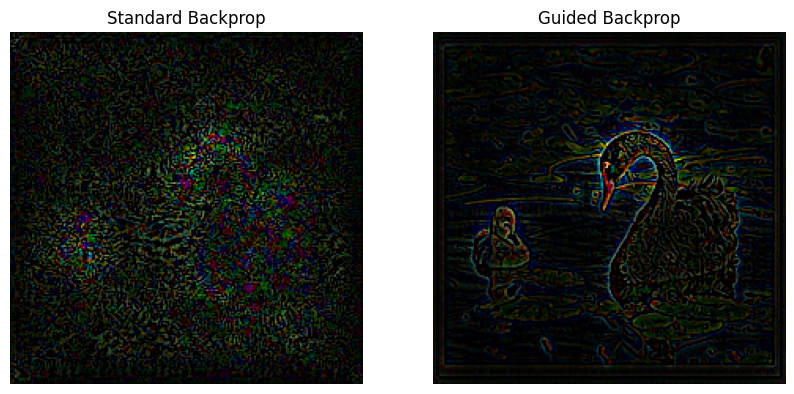

In [28]:
# Get the image gradients
grads = img_tensor.grad.detach().cpu().numpy().squeeze()

grads = process_grads(grads,activation="relu")

fig,ax = plt.subplots(1,2,figsize=(10,5))

# Display the gradients
ax[0].imshow(relu_grads)
ax[0].title.set_text("Standard Backprop")

ax[1].imshow(grads)
ax[1].title.set_text("Guided Backprop")

for a in ax:
    a.axis("off")

for intermediate layer 

(64, 224, 224)
i : 60


(-0.5, 223.5, 223.5, -0.5)

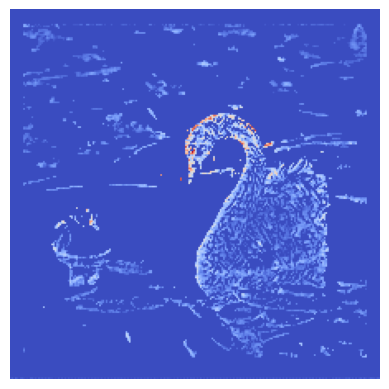

In [42]:

# Gradients from the first layer
layer = 'features.1'

# Get gradients for all feature map in layer
layer_grads = gradients[layer]
print(layer_grads.shape)

# Select a random feature map
i = np.random.randint(0, layer_grads.shape[0])
print(f"i : {i}")
feature_map_grads = layer_grads[i]

# Processing the gradients
feature_map_grads = process_grads(feature_map_grads)

# Display the gradients
plt.imshow(feature_map_grads, cmap="coolwarm")
plt.axis("off")


features.1: (64, 224, 224)
features.6: (128, 112, 112)
features.13: (256, 56, 56)
features.22: (512, 28, 28)


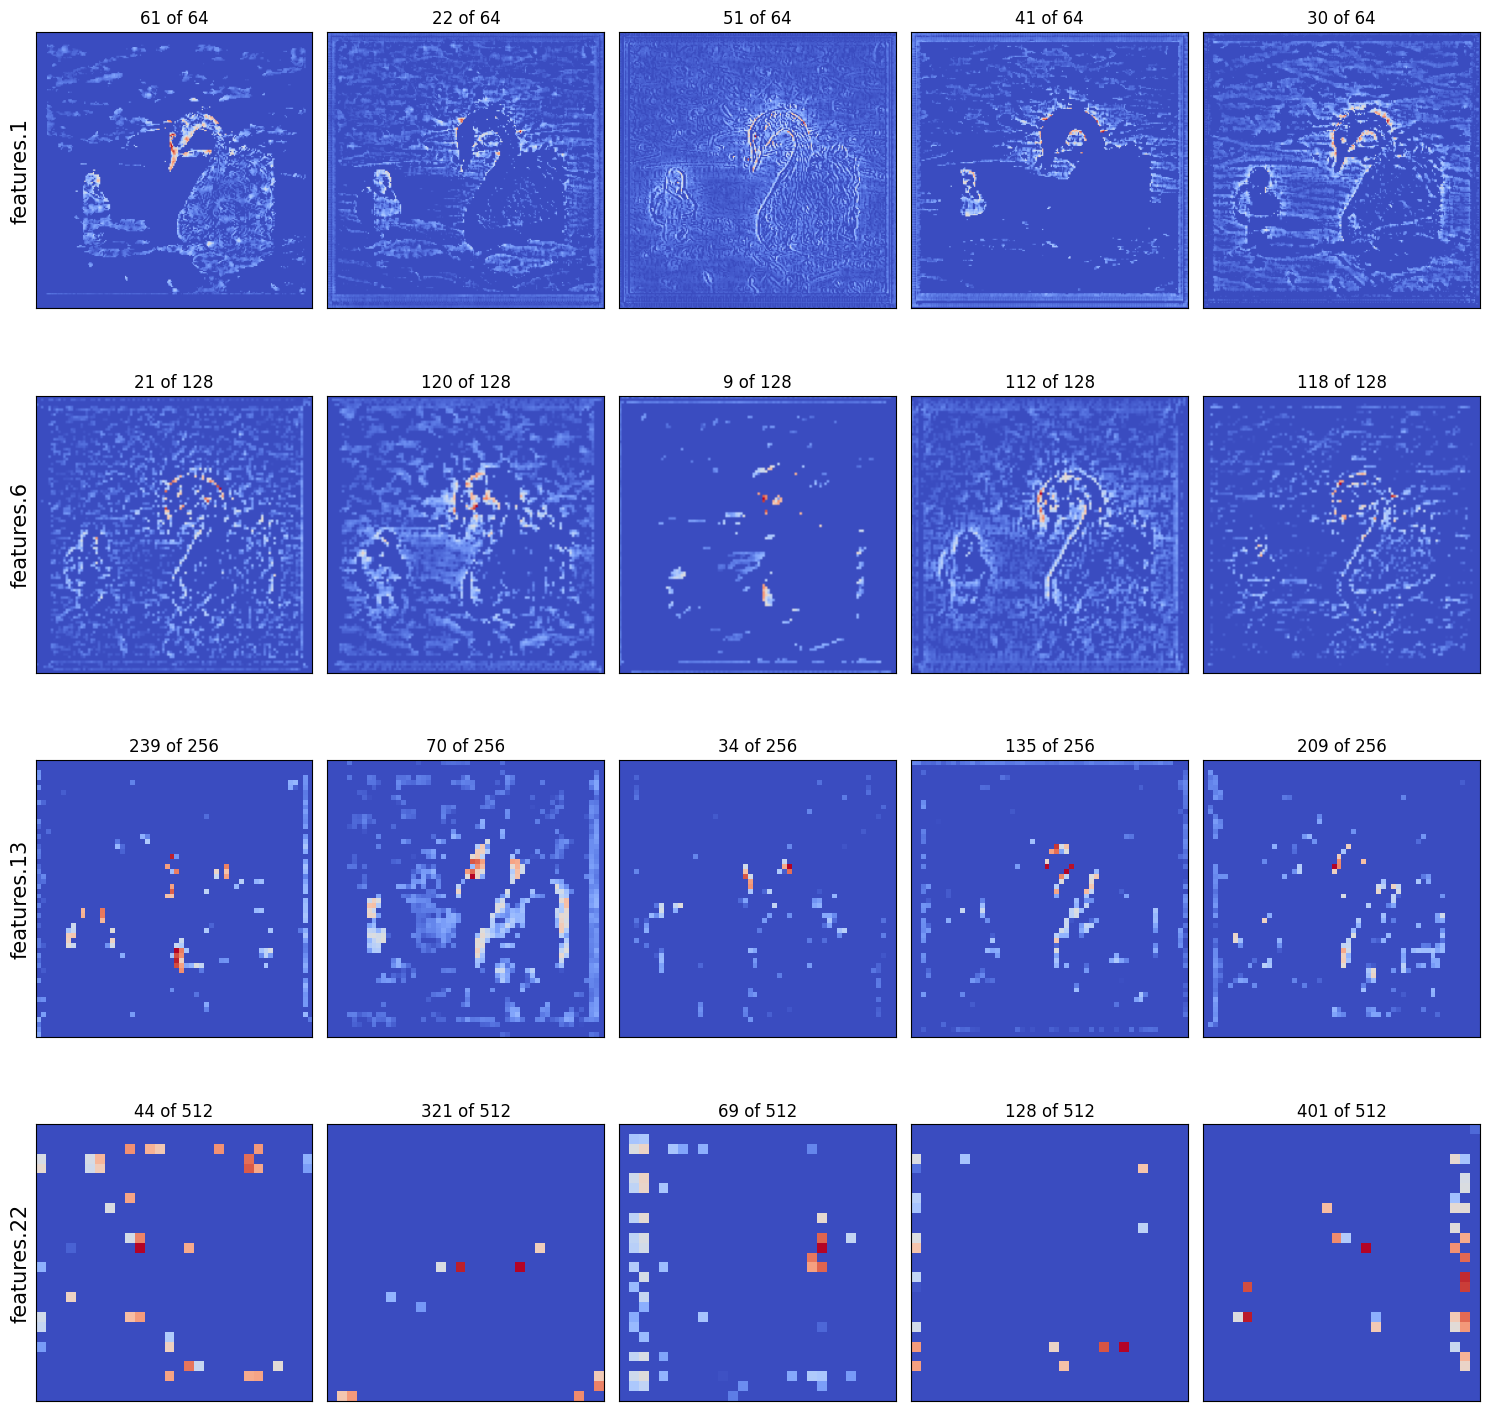

In [43]:
fig, ax = plt.subplots(4, 5, figsize=(15, 15))

for i,layer in enumerate(['features.1','features.6','features.13','features.22']):
    layer_grads = gradients[layer]
    print(f"{layer}: {layer_grads.shape}")

    for j in range(5):
        n_features = layer_grads.shape[0]
        r = np.random.randint(0, n_features)

        feature_map_grads = layer_grads[r]
        feature_map_grads = process_grads(feature_map_grads)

        ax[i, j].imshow(feature_map_grads, cmap="coolwarm")
    
        ax[i, j].set_title(f"{r} of {n_features}")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
          
    ax[i, 0].set_ylabel(f"{layer}", fontsize=15)

plt.tight_layout()

Guided Backprop from activation

In [44]:
# Dictionary to store activations
activations = {}

def act_hook_fn(module, input, output, layer_name):
    """
    Hook function to store activations of a layer.

    Parameters:
        module (nn.Module): The module where the hook is applied.
        input (tuple of Tensors): Incoming data to the layer.
        output (Tensor): Outgoing data from the layer.
        layer_name (str): The name of the layer.
    """
    # Store the activations as tensors
    activations[layer_name] = output.clone()
    print(f"Activation stored for {layer_name}")


# Register hooks on all convolutional layers
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(lambda m, i, o, n=name: act_hook_fn(m, i, o, n))
        print(f"Forward hook registered for {name}")





Forward hook registered for features.0
Forward hook registered for features.2
Forward hook registered for features.5
Forward hook registered for features.7
Forward hook registered for features.10
Forward hook registered for features.12
Forward hook registered for features.14
Forward hook registered for features.17
Forward hook registered for features.19
Forward hook registered for features.21
Forward hook registered for features.24
Forward hook registered for features.26
Forward hook registered for features.28


In [45]:
# Reset gradients
img_tensor = original_img_tensor.clone()
img_tensor.requires_grad_() 
model.zero_grad()

# Perform a forward pass
predictions = model(img_tensor)

# Get the activations of the conv layers
layer_act = activations['features.21'][0]
print(layer_act.shape) # (512, 28, 28)

Activation stored for features.0
Activation stored for features.2
Activation stored for features.5
Activation stored for features.7
Activation stored for features.10
Activation stored for features.12
Activation stored for features.14
Activation stored for features.17
Activation stored for features.19
Activation stored for features.21
Activation stored for features.24
Activation stored for features.26
Activation stored for features.28
torch.Size([512, 28, 28])


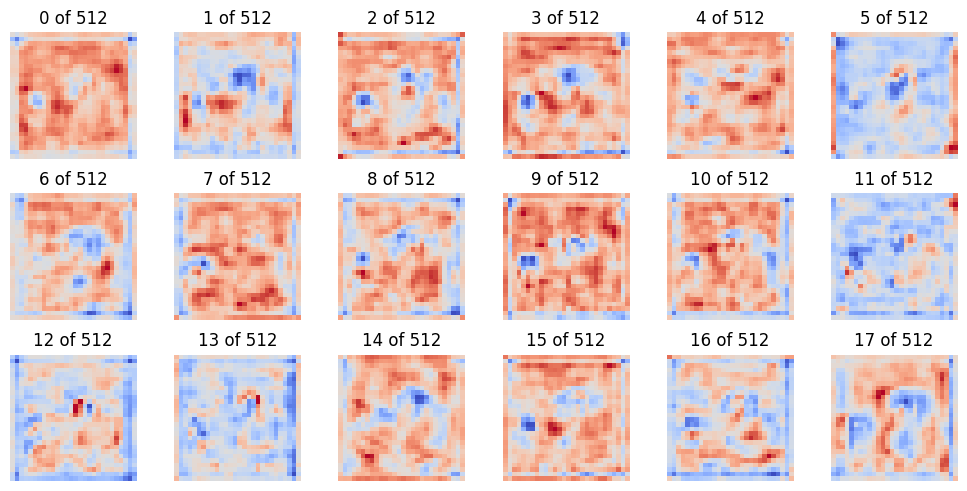

In [46]:
# Plot the activations
fig, ax = plt.subplots(3, 6, figsize=(10, 5))

for i, act in enumerate(layer_act[0:18]):

    act_copy = act.clone().detach().cpu().numpy()
    act_copy = process_grads(act_copy,skew= False)
    
    ax[i // 6, i % 6].imshow(act_copy, cmap="coolwarm")
    ax[i // 6, i % 6].set_title(f"{i} of {layer_act.shape[0]}")
    ax[i // 6, i % 6].axis("off")

plt.tight_layout()

In [ ]:
# Compute gradients w.r.t element of the activation map
layer_act[0][14,14].backward()

(-0.5, 223.5, 223.5, -0.5)

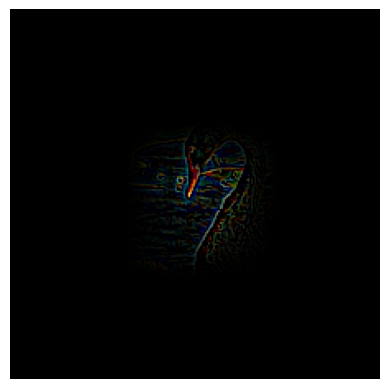

In [48]:
# Get the gradients of input image
grads = img_tensor.grad.detach().cpu().numpy().squeeze()

grads = process_grads(grads, activation="relu")

plt.imshow(grads)
plt.axis("off")